## Introduction<a id='introduction'></a>

**Purpose:** \
To quantify the effect of offering tech support and a discount to potential clients on the company's revenue and to develop a campaign strategy that maximizes revenue.

Questions to answer:
- What percentage of customers should be offered each campaign to maximize revenue?
    - All customers should be offered tech support
        - Would go so far as to suggest the company incorporate tech support as a function of the software package or as an add-on
    - 98% of customers should be offered a discount
        - Offering 50% a discount will also net 87% of the gain (if offering discount to 98% of customers)
- What type of customers result in greatest uplift? SMC? Global? etc.
    - Largely determined by Size, followed by Global and Major

**Context:** \
A software company ran two sales campaigns, offering tech support and/or a discount to potential customers, and would like to know the impact of the campaigns on increasing the company's revenue. The company also wants to quantify the success or failure of the two campaigns and how should the company re-run the campaign(s) if it chooses to do so. 

**Method:** \
Approximating conditional average treatment effect using S-learner and T-learner approach.

**Data:** \
Data comes from [Kaggle](https://www.kaggle.com/datasets/hwwang98/software-usage-promotion-campaign-uplift-model)

From data card, columns are
1) Global Flag: Whether customer has global offices
2) Major Flag: Whether customer is a large customer in their industry (as opposed to small medium corporation)
3) SMC Flag: Whether customer is small medium corporation
4) Commercial Flag: Whether the customer's business is commercial as opposed to public sector
5) IT Spend: (\$) spent on IT-related purchases
6) Employee Count: Number of employees
7) PC Count: number of PCs used by the customer
8) Size: Customer's size given their yearly revenue
9) Tech Support: (treatment; binary) whether customer received tech support
10) Discount: (treatment; binary) whether customer was given a discount
11) Revenue: (outcome; \$) revenue from customer

**Outcomes from EDA:** 

1. Revenue driven by a few customers.
    - Top 25% of customers bring in 50% of revenue
    - Bottom 25% of customers contribute only 8% of revenue
2. Both providing tech support and offering a discount have a positive average treatment effect.
    - For tech support only ATE: 8518.22 $\pm$ 6355.26
    - For discount only ATE: 5662.05 $\pm$ 8185.68
    - For both tech support and discount ATE: 20198.23 $\pm$ 13536.51
3. Both sales initiatives appear to have a positive effect in acquiring customers.
    - Of top 25% of customers, 85% were provided tech support and 84% received a discount
    - Of bottom 25% of customers, 4% were provided tech support and 29% received a discount
4. Targetting larger customers may increase revenue and not offering tech support and discounts to smaller customers may reduce expense. 

## Contents<a id='contents'></a> 

* [Introduction](#introduction)
* [Contents](#contents)
* [Objectives](#objectives)
* [Approximating Treatment Effect](#approximating_treatment_effect)
    * [S-Learner](#s-learner)
        * [Multiple Linear Regression](#mlr_s-learner)
        * [Random Forest](#random_forest_s-learner)
    * [T-learner](#t-learner)
        * [Multiple Linear Regression](#mlr_t-learner)
            * [No Tech Support, No Discount](#(mlr_no_ts_no_d)
            * [Tech Support, No Discount](#(mlr_ts_no_d)
            * [No Tech Support, Discount](#(mlr_no_ts_d)
            * [Tech Support, Discount](#(mlr_ts_d)
        * [Random Forest](#random_forest_t-learner)
            * [No Tech Support, No Discount](#(rf_no_ts_no_d)
            * [Tech Support, No Discount](#(rf_ts_no_d)
            * [No Tech Support, Discount](#(rf_no_ts_d)
            * [Tech Support, Discount](#(rf_ts_d)
* [Cumulative Gain](#cumulative_gain)
    * [S-Learner](#cum_gain_s-learner)
    * [T-Learner](#cum_gain_t-learner)
* [Cumulative Lift](#cumulative_lift)
    * [S-Learner](#cum_lift_s-learner)
    * [T-Learner](#cum_lift_t-learner)

## Objectives <a id='objectives'></a>

1) Identify the best model to approximate treatment effects.
    - **Both S-Learner and T-Learner approach are suitable.**
        - **For S-Learner approach, Random Forest Regressor outperforms Linear Regressor.**
        - **For T-Learner approach, Linear Regressors outperform Random Forest Regressors.**
    - **For simplicity, suggest going with T-Learners and Linear Regressors.**
2) Answer the following questions:
    - What percentage of customers should be offered each campaign to maximize revenue?
        - **All customers should be offered tech support**
            - **So long as cost of tech support does not exceed $7000 per customer**
        - **98% of customers should be offered a discount**
            - **Offering discount to 50% of customers will net 87% of the gain (if 98% of customers are offered a discount)**
    - What type of customers result in greatest uplift? SMC? Global? etc.
        - **Largely determined by Size, then Global and Major**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/raw/multi_attribution_sample.csv')

## Approximating Treament Effect <a id='approximating_treatment_effect'></a>

**Result:**

Saw from data wrangling that IT Spend, Employee Count, PC Count, and Size were exponentially distributed. \
So, as a step in the preprocessing phase, going to transform IT Spend, Employee Count, PC Count, and Size according to their respective exponential distributions. This will create a linear representation of occurence. \
The binwidths used for IT Spend, Employee Count, PC Count, and Size are 6000, 10, 10, and 20000, respectively. \
The last 5 bins should be thrown out for fitting for lack of observations.

In [3]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor

In [4]:
def gen_1d_distribution(data, binwidth):
    my_min, my_max = min(data), max(data)
    bins = np.arange(my_min, my_max+binwidth, binwidth) + binwidth/2
    counts = np.zeros(len(bins))
    
    for x in data:
        bin_ind = (x-my_min)//binwidth
        counts[bin_ind] += 1
    counts /= len(data)
    
    # removing zero counts
    inds = [ind for ind,val in enumerate(counts) if val != 0]
    
    return np.array([bins[inds], counts[inds]]).T

In [5]:
class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column=None, binwidth=None):
        self.column = column
        self.binwidth = binwidth
    def fit(self, X, y=None):
        distr = gen_1d_distribution(X[self.column], self.binwidth)
        lin_reg = LinearRegression()
        lin_reg.fit(distr[:-5,0].reshape(-1,1), np.log(distr[:-5,1]))
        self.model = lin_reg
        return self
    def transform(self, X):
        return self.model.predict(X[self.column].values.reshape(-1,1)).reshape(-1,1)

In [6]:
# split train, test
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='Revenue'), df[['Revenue']], test_size=0.1)

features = FeatureUnion([
    ('bin_trans', ColumnTransformer([('flags', 'passthrough', ['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag'])])),
    ('it_trans', NumericalTransformer(column='IT Spend', binwidth=6000)),
    ('employee_trans', NumericalTransformer(column='Employee Count', binwidth=10)),
    ('pc_trans', NumericalTransformer(column='PC Count', binwidth=10)),
    ('size_trans', NumericalTransformer(column='Size', binwidth=20000)),
    ('treatment_trans', ColumnTransformer([('treatments', 'passthrough', ['Tech Support', 'Discount'])]))
])

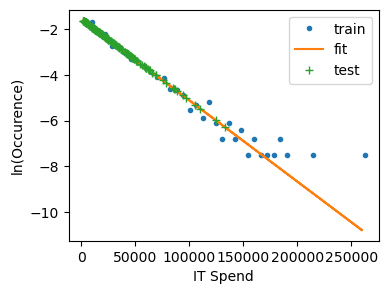

In [7]:
col, binwidth = 'IT Spend', 6000
distr = gen_1d_distribution(x_train['IT Spend'], binwidth)
features['it_trans'].fit(x_train)
plt.subplots(figsize=(4,3))
plt.plot(distr[:,0], np.log(distr[:,1]), '.', label='train')
plt.plot(x_train['IT Spend'], features['it_trans'].transform(x_train), label='fit')
plt.plot(x_test['IT Spend'], features['it_trans'].transform(x_test), '+', label='test')
plt.xlabel('IT Spend')
plt.ylabel('ln(Occurence)')
plt.legend(loc=1)

### S-Learner <a id='s-learner'></a>

**Result:**

- RandomForestRegressor(n_estimators=125, criterion='absolute_error', max_samples=1080, max_features=7) outperforms linear regressor.
- Random forest has slight tendency to overpredict revenue gain
    - Would rather overpredict revenue gain than underpredict. Underpredicting may drive sales team to underprioritize high revenue customers
- Stats for random forest:
    - Mean absolute percent error (%): 13.58
    - Std absolute percent error (%): 26.88
    - Mean percent error (%): 4.26
    - Std percent error (%): 29.81
    - Median percent error (%): 0.37

#### Multiple Linear Regression <a id='mlr_s-learner'></a>

**Result:** 
- Best model appears to be ElasticNet(alpha=0.1, l1_ratio=0.9) with no noticeable difference between scoring on mean absolute error or mean squared error.
- Predictions are normally distributed around 0%, but are also widely distributed.
- Stats:
    - Mean absolute percent error (%): 21.10
    - Std absolute percent error (%): 32.48
    - Mean percent error (%): -2.38
    - Std percent error (%): 38.66
    - Median percent error (%): 1.14
    - About 20% of predictions are more than 50% off with 1% of predictions being more than 100% off. 

In [8]:
# split train, test
columns = df.columns.drop('Revenue')
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='Revenue'), df[['Revenue']], test_size=0.1)

features = FeatureUnion([
    ('bin_trans', ColumnTransformer([('flags', 'passthrough', ['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag'])])),
    ('it_trans', NumericalTransformer(column='IT Spend', binwidth=6000)),
    ('employee_trans', NumericalTransformer(column='Employee Count', binwidth=10)),
    ('pc_trans', NumericalTransformer(column='PC Count', binwidth=10)),
    ('size_trans', NumericalTransformer(column='Size', binwidth=20000)),
    ('treatment_trans', ColumnTransformer([('treatments', 'passthrough', ['Tech Support', 'Discount'])]))
])

x_train, x_test = features.fit_transform(x_train), features.transform(x_test)

In [9]:
# scoring on mean absolute error
lr_model = ElasticNet()
grid_params = {'alpha':np.arange(0.025, 0.15, 0.025), 'l1_ratio':np.arange(0.85, 1, 0.025)}
gridsearch_lr = GridSearchCV(lr_model, grid_params, scoring='neg_mean_absolute_error', return_train_score=True, cv=5)

In [10]:
gridsearch_lr.fit(x_train, y_train)
abs_percent_error = np.abs((gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
print(gridsearch_lr.best_estimator_)
print('neg mean absolute error (on val): {:.2f}'.format(gridsearch_lr.best_score_))
print('mean absolute percent error (on test): {:.2f}'.format(np.mean(abs_percent_error)))
print('std absolute percent error (on test): {:.2f}'.format(np.std(abs_percent_error)))
print('percent error (on test): {:.4f}'.format(np.sum(gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/np.sum(y_test.values)))

ElasticNet(alpha=0.07500000000000001, l1_ratio=0.875)
neg mean absolute error (on val): -1939.08
mean absolute percent error (on test): 0.20
std absolute percent error (on test): 0.24
percent error (on test): -0.0018


Text(0, 0.5, 'Percent Error on Test Set')

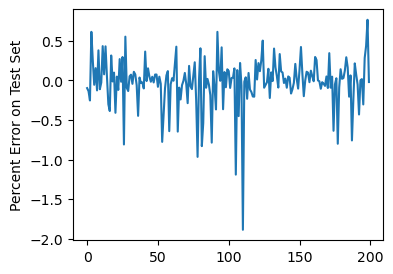

In [11]:
plt.subplots(figsize=(4,3))
plt.plot((gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
plt.ylabel('Percent Error on Test Set')

In [12]:
# scoring on mean squared error
lr_model = ElasticNet()
grid_params = {'alpha':np.arange(0.025, 0.15, 0.025), 'l1_ratio':np.arange(0.85, 1, 0.025)}
gridsearch_lr = GridSearchCV(lr_model, grid_params, scoring='neg_root_mean_squared_error', return_train_score=True, cv=5)

In [13]:
gridsearch_lr.fit(x_train, y_train)
abs_percent_error = np.abs((gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
print(gridsearch_lr.best_estimator_)
print('neg mean absolute error (on val): {:.2f}'.format(gridsearch_lr.best_score_))
print('mean absolute percent error (on test): {:.2f}'.format(np.mean(abs_percent_error)))
print('std absolute percent error (on test): {:.2f}'.format(np.std(abs_percent_error)))
print('percent error (on test): {:.4f}'.format(np.sum(gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/np.sum(y_test.values)))

ElasticNet(alpha=0.025, l1_ratio=0.9750000000000001)
neg mean absolute error (on val): -2625.44
mean absolute percent error (on test): 0.20
std absolute percent error (on test): 0.26
percent error (on test): -0.0019


Text(0, 0.5, 'Percent Error on Test Set')

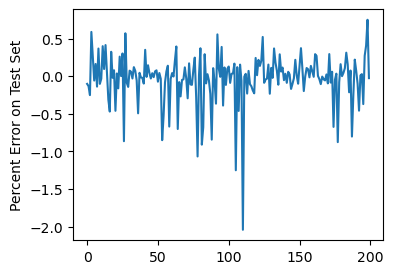

In [14]:
plt.subplots(figsize=(4,3))
plt.plot((gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
plt.ylabel('Percent Error on Test Set')

In [15]:
# Calculating percent error for whole dataset using cross validation. Hyperparameters are alpha=0.1, l1_ratio=0.9
XY = df.sample(frac=1)
X, Y = XY.drop(columns='Revenue'), XY[['Revenue']]
batch_size = 400

percent_error = np.zeros(df.shape[0])

for i in range(int(df.shape[0]/batch_size)):
    start, stop = i*batch_size, (i+1)*batch_size
    x_train, x_test = pd.concat([X.iloc[:start], X.iloc[stop:]]), X.iloc[start:stop]
    y_train, y_test = pd.concat([Y.iloc[:start], Y.iloc[stop:]]), Y.iloc[start:stop]
    
    x_train, x_test = features.fit_transform(x_train), features.transform(x_test)
    
    lr_model = ElasticNet(alpha=0.1, l1_ratio=0.9)
    lr_model.fit(x_train, y_train)
    
    percent_error[start:stop] = (lr_model.predict(x_test) - y_test.values.reshape(-1))/y_test.values.reshape(-1)

Mean absolute percent error (%): 21.15
Std absolute percent error (%): 32.73
Mean percent error (%): -2.34
Std percent error (%): 38.90
Median percent error (%): 1.08


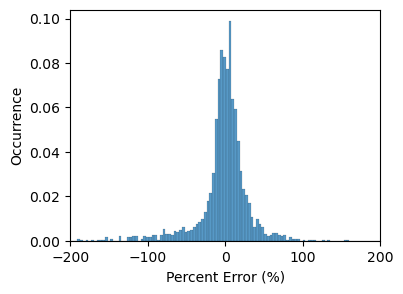

In [16]:
plt.subplots(figsize=(4,3))
sns.histplot(percent_error*100, stat='probability')
plt.xlim([-200, 200])
plt.ylabel('Occurrence')
plt.xlabel('Percent Error (%)')
print('Mean absolute percent error (%): {:.2f}'.format(np.mean(np.abs(percent_error))*100))
print('Std absolute percent error (%): {:.2f}'.format(np.std(np.abs(percent_error))*100))
print('Mean percent error (%): {:.2f}'.format(np.mean(percent_error)*100))
print('Std percent error (%): {:.2f}'.format(np.std(percent_error)*100))
print('Median percent error (%): {:.2f}'.format(np.median(percent_error)*100))

In [17]:
print(columns)
print(lr_model.coef_)

Index(['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'IT Spend',
       'Employee Count', 'PC Count', 'Size', 'Tech Support', 'Discount'],
      dtype='object')
[ 3842.13528651  1537.38430302    52.10599532  1001.6435221
   245.77812056  -437.4785471  -1961.44007581 -8225.74082026
  6737.41474731  4998.64448211]


Size, Tech Support, and Discount most strongly correlate with revenue. Note that because Size was transformed, the negative coefficient does indicate that larger customers generate more revenue

#### Random Forest <a id='random_forest_s-learner'></a>

**Result:**
- Best model appears to be RandomForestRegressor(n_estimators=125, criterion='absolute_error', max_samples=1080, max_features=7) with minor differences in tuning hyperparameters
- Predictions are normally distributed around 0% and more tightly distributed than linear regressor
- While linear regressor tends to underpredict revenue, random forest tends to overpredict
- Stats:
    - Mean absolute percent error (%): 13.58
    - Std absolute percent error (%): 26.88
    - Mean percent error (%): 4.26
    - Std percent error (%): 29.81
    - Median percent error (%): 0.37

In [18]:
# split train, test
columns = df.columns.drop('Revenue')
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='Revenue'), df[['Revenue']], test_size=0.1)

features = FeatureUnion([
    ('bin_trans', ColumnTransformer([('flags', 'passthrough', ['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag'])])),
    ('it_trans', NumericalTransformer(column='IT Spend', binwidth=6000)),
    ('employee_trans', NumericalTransformer(column='Employee Count', binwidth=10)),
    ('pc_trans', NumericalTransformer(column='PC Count', binwidth=10)),
    ('size_trans', NumericalTransformer(column='Size', binwidth=20000)),
    ('treatment_trans', ColumnTransformer([('treatments', 'passthrough', ['Tech Support', 'Discount'])]))
])

x_train, x_test = features.fit_transform(x_train), features.transform(x_test)

In [19]:
# scoring on mean absolute error
rf_model = RandomForestRegressor()
grid_params = {'n_estimators':[100, 125, 150], 
               'criterion':['squared_error','absolute_error'],
               'max_samples':[900, 1080],
               'max_features':[5, 7]}
gridsearch_rf = GridSearchCV(rf_model, grid_params, return_train_score=True, cv=5)

In [20]:
gridsearch_rf.fit(x_train, np.ravel(y_train))
abs_percent_error = np.abs((gridsearch_rf.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
print(gridsearch_rf.best_estimator_)
print('neg mean absolute error (on val): {:.2f}'.format(gridsearch_rf.best_score_))
print('mean absolute percent error (on test): {:.2f}'.format(np.mean(abs_percent_error)))
print('std absolute percent error (on test): {:.2f}'.format(np.std(abs_percent_error)))
print('percent error (on test): {:.4f}'.format(np.sum(gridsearch_rf.predict(x_test).reshape(-1,1) - y_test.values)/np.sum(y_test.values)))

RandomForestRegressor(criterion='absolute_error', max_features=7,
                      max_samples=1080, n_estimators=150)
neg mean absolute error (on val): 0.97
mean absolute percent error (on test): 0.13
std absolute percent error (on test): 0.21
percent error (on test): -0.0186


Text(0, 0.5, 'Percent Error on Test Set')

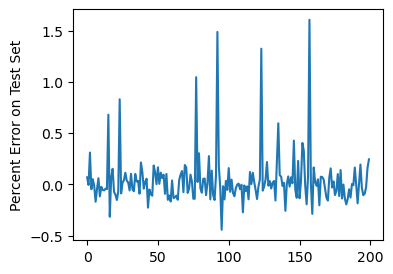

In [21]:
plt.subplots(figsize=(4,3))
plt.plot((gridsearch_rf.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
plt.ylabel('Percent Error on Test Set')

In [22]:
# Calculating percent error for whole dataset using cross validation. 
# Hyperparameters are n_estimators=125, criterion='absolute_error', max_samples=1080, max_features=7
XY = df.sample(frac=1)
X, Y = XY.drop(columns='Revenue'), XY[['Revenue']]
batch_size = 400

percent_error = np.zeros(df.shape[0])

for i in range(int(df.shape[0]/batch_size)):
    start, stop = i*batch_size, (i+1)*batch_size
    x_train, x_test = pd.concat([X.iloc[:start], X.iloc[stop:]]), X.iloc[start:stop]
    y_train, y_test = pd.concat([Y.iloc[:start], Y.iloc[stop:]]), Y.iloc[start:stop]
    
    x_train, x_test = features.fit_transform(x_train), features.transform(x_test)
    
    rf_model = RandomForestRegressor(n_estimators=125, criterion='absolute_error', max_samples=1080, max_features=7)
    rf_model.fit(x_train, np.ravel(y_train))
    
    percent_error[start:stop] = (rf_model.predict(x_test) - y_test.values.reshape(-1))/y_test.values.reshape(-1)

Mean absolute percent error (%): 13.62
Std absolute percent error (%): 26.38
Mean percent error (%): 4.05
Std percent error (%): 29.42
Median percent error (%): 0.35


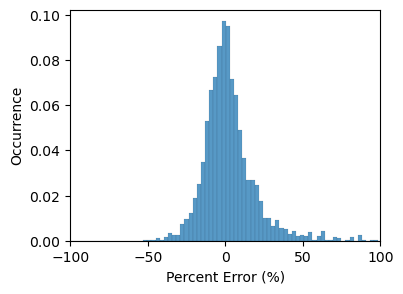

In [23]:
plt.subplots(figsize=(4,3))
sns.histplot(percent_error*100, stat='probability')
plt.xlim([-100, 100])
plt.ylabel('Occurrence')
plt.xlabel('Percent Error (%)')
print('Mean absolute percent error (%): {:.2f}'.format(np.mean(np.abs(percent_error))*100))
print('Std absolute percent error (%): {:.2f}'.format(np.std(np.abs(percent_error))*100))
print('Mean percent error (%): {:.2f}'.format(np.mean(percent_error)*100))
print('Std percent error (%): {:.2f}'.format(np.std(percent_error)*100))
print('Median percent error (%): {:.2f}'.format(np.median(percent_error)*100))

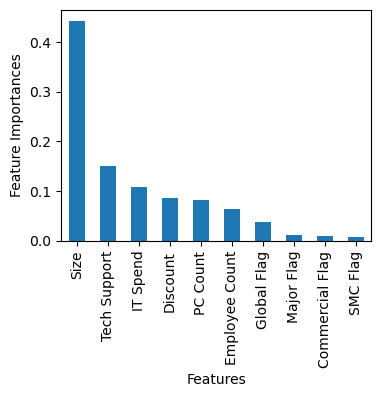

In [24]:
plt.subplots(figsize=(4,3))
feature_importances = pd.Series(rf_model.feature_importances_, index=columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.ylabel('Feature Importances')
plt.xlabel('Features');

### T-Learner <a id='t-learner'></a>

**Result:**
- Linear Regression performs better than Random Forest
    - 4.8% (7% std) absolute percent error for treated groups vs 9% (10.5% std) absolute percent error for treated groups, LR and RF, respectively
- LR Hyperparameters for each group:
    - ElasticNet(alpha=0.025, l1_ratio=0.975) for untreated
    - ElasticNet(alpha=0.025, l1_ratio=0.975) for tech support, no discount
    - ElasticNet(alpha=0.025, l1_ratio=1) for no tech support, discount
    - ElasticNet(alpha=0.025, l1_ratio=1) for tech support, discount

In [25]:
# splitting df by treatment variables. 
# Using df00 to designate no tech support and no discount, df10 to designate tech support and no discount, etc.
df00 = df[(df['Tech Support']==0) & (df['Discount']==0)]
df10 = df[(df['Tech Support']==1) & (df['Discount']==0)]
df01 = df[(df['Tech Support']==0) & (df['Discount']==1)]
df11 = df[(df['Tech Support']==1) & (df['Discount']==1)]

In [26]:
features = FeatureUnion([
    ('bin_trans', ColumnTransformer([('flags', 'passthrough', ['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag'])])),
    ('it_trans', NumericalTransformer(column='IT Spend', binwidth=6000)),
    ('employee_trans', NumericalTransformer(column='Employee Count', binwidth=10)),
    ('pc_trans', NumericalTransformer(column='PC Count', binwidth=10)),
    ('size_trans', NumericalTransformer(column='Size', binwidth=20000))
])

#### Multiple Linear Regression <a id='mlr_t-learner'></a>

**Result:**
- Generally performs well with 4.8% (7% std) absolute percent error on treated groups
- Does not perform well for untreated group

##### No Tech Support, No Discount <a id='mlr_no_ts_no_d'></a>

**Result:**

- Global Flag, Major Flag, and PC Count
- Stats
    - Mean absolute percent error (%): 14.90
    - Std absolute percent error (%): 27.96
    - Mean percent error (%): 4.85
    - Std percent error (%): 31.31
    - Median percent error (%): 0.00

In [13]:
# split train, test
columns = df00.columns.drop('Revenue')
x_train, x_test, y_train, y_test = train_test_split(df00.drop(columns='Revenue'), df00[['Revenue']], test_size=0.1)

x_train, x_test = features.fit_transform(x_train), features.transform(x_test)

In [55]:
# scoring on mean absolute error
lr_model = ElasticNet()
grid_params = {'alpha':np.arange(0.025, 0.15, 0.025), 'l1_ratio':np.arange(0.85, 1, 0.025)}
gridsearch_lr = GridSearchCV(lr_model, grid_params, scoring='neg_root_mean_squared_error', return_train_score=True, cv=5)

In [56]:
gridsearch_lr.fit(x_train, y_train)
abs_percent_error = np.abs((gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
print(gridsearch_lr.best_estimator_)
print('neg mean absolute error (on val): {:.2f}'.format(gridsearch_lr.best_score_))
print('mean absolute percent error (on test): {:.2f}'.format(np.mean(abs_percent_error)))
print('std absolute percent error (on test): {:.2f}'.format(np.std(abs_percent_error)))
print('percent error (on test): {:.4f}'.format(np.sum(gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/np.sum(y_test.values)))

ElasticNet(alpha=0.025, l1_ratio=0.9750000000000001)
neg mean absolute error (on val): -1003.23
mean absolute percent error (on test): 0.22
std absolute percent error (on test): 0.54
percent error (on test): -0.0151


Text(0, 0.5, 'Percent Error on Test Set')

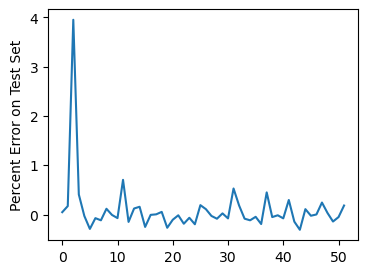

In [57]:
plt.subplots(figsize=(4,3))
plt.plot((gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
plt.ylabel('Percent Error on Test Set')

In [14]:
# Calculating percent error for whole dataset using cross validation. Hyperparameters are alpha=0.025, l1_ratio=0.975
XY = df00.sample(frac=1)
X, Y = XY.drop(columns='Revenue'), XY[['Revenue']]
batch_size = 104

percent_error = np.zeros(df00.shape[0])

for i in range(int(df00.shape[0]/batch_size)):
    start, stop = i*batch_size, (i+1)*batch_size
    x_train, x_test = pd.concat([X.iloc[:start], X.iloc[stop:]]), X.iloc[start:stop]
    y_train, y_test = pd.concat([Y.iloc[:start], Y.iloc[stop:]]), Y.iloc[start:stop]
    
    x_train, x_test = features.fit_transform(x_train), features.transform(x_test)
    
    lr_model = ElasticNet(alpha=0.025, l1_ratio=0.975)
    lr_model.fit(x_train, y_train)
    
    percent_error[start:stop] = (lr_model.predict(x_test) - y_test.values.reshape(-1))/y_test.values.reshape(-1)

Mean absolute percent error (%): 14.98
Std absolute percent error (%): 28.78
Mean percent error (%): 4.29
Std percent error (%): 32.16
Median percent error (%): 0.00


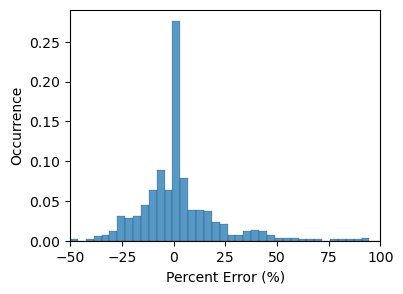

In [16]:
plt.subplots(figsize=(4,3))
sns.histplot(percent_error*100, stat='probability')
plt.xlim([-50, 100])
plt.ylabel('Occurrence')
plt.xlabel('Percent Error (%)')
print('Mean absolute percent error (%): {:.2f}'.format(np.mean(np.abs(percent_error))*100))
print('Std absolute percent error (%): {:.2f}'.format(np.std(np.abs(percent_error))*100))
print('Mean percent error (%): {:.2f}'.format(np.mean(percent_error)*100))
print('Std percent error (%): {:.2f}'.format(np.std(percent_error)*100))
print('Median percent error (%): {:.2f}'.format(np.median(percent_error)*100))

In [65]:
print(X.columns.drop(['Tech Support', 'Discount']))
print(lr_model.coef_)

Index(['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'IT Spend',
       'Employee Count', 'PC Count', 'Size'],
      dtype='object')
[ 3920.80992001  2266.06578796   537.08255053  1039.3275977
  -207.07680534    45.48147875 -2176.33638717 -1606.95330475]


##### Tech Support, No Discount <a id='mlr_ts_no_d'></a>

**Result:**
- Size, Global Flag, PC Count most important
- Stats:
    - Mean absolute percent error (%): 4.94
    - Std absolute percent error (%): 5.83
    - Mean percent error (%): 0.56
    - Std percent error (%): 7.62
    - Median percent error (%): 0.00

In [105]:
# split train, test
columns = df10.columns.drop('Revenue')
x_train, x_test, y_train, y_test = train_test_split(df10.drop(columns='Revenue'), df10[['Revenue']], test_size=0.1)

x_train, x_test = features.fit_transform(x_train), features.transform(x_test)

In [106]:
# scoring on mean absolute error
lr_model = ElasticNet()
grid_params = {'alpha':np.arange(0.025, 0.15, 0.025), 'l1_ratio':np.arange(0.85, 1, 0.025)}
gridsearch_lr = GridSearchCV(lr_model, grid_params, scoring='neg_root_mean_squared_error', return_train_score=True, cv=5)

In [107]:
gridsearch_lr.fit(x_train, y_train)
abs_percent_error = np.abs((gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
print(gridsearch_lr.best_estimator_)
print('neg mean absolute error (on val): {:.2f}'.format(gridsearch_lr.best_score_))
print('mean absolute percent error (on test): {:.2f}'.format(np.mean(abs_percent_error)))
print('std absolute percent error (on test): {:.2f}'.format(np.std(abs_percent_error)))
print('percent error (on test): {:.4f}'.format(np.sum(gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/np.sum(y_test.values)))

ElasticNet(alpha=0.025, l1_ratio=0.9750000000000001)
neg mean absolute error (on val): -1029.13
mean absolute percent error (on test): 0.06
std absolute percent error (on test): 0.05
percent error (on test): -0.0060


Text(0, 0.5, 'Percent Error on Test Set')

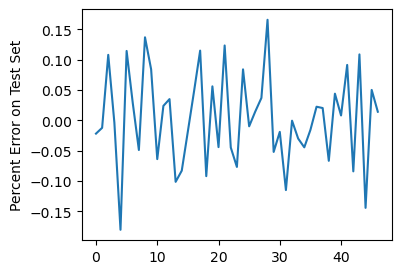

In [108]:
plt.subplots(figsize=(4,3))
plt.plot((gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
plt.ylabel('Percent Error on Test Set')

In [17]:
# Calculating percent error for whole dataset using cross validation. Hyperparameters are alpha=0.025, l1_ratio=0.975
XY = df10.sample(frac=1)
X, Y = XY.drop(columns='Revenue'), XY[['Revenue']]
batch_size = 93

percent_error = np.zeros(df10.shape[0])

for i in range(int(df10.shape[0]/batch_size)):
    start, stop = i*batch_size, (i+1)*batch_size
    x_train, x_test = pd.concat([X.iloc[:start], X.iloc[stop:]]), X.iloc[start:stop]
    y_train, y_test = pd.concat([Y.iloc[:start], Y.iloc[stop:]]), Y.iloc[start:stop]
    
    x_train, x_test = features.fit_transform(x_train), features.transform(x_test)
    
    lr_model = ElasticNet(alpha=0.025, l1_ratio=0.975)
    lr_model.fit(x_train, y_train)
    
    percent_error[start:stop] = (lr_model.predict(x_test) - y_test.values.reshape(-1))/y_test.values.reshape(-1)

Mean absolute percent error (%): 4.94
Std absolute percent error (%): 5.88
Mean percent error (%): 0.61
Std percent error (%): 7.66
Median percent error (%): 0.00


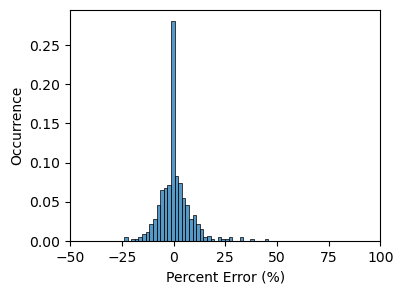

In [19]:
plt.subplots(figsize=(4,3))
sns.histplot(percent_error*100, stat='probability')
plt.xlim([-50, 100])
plt.ylabel('Occurrence')
plt.xlabel('Percent Error (%)')
print('Mean absolute percent error (%): {:.2f}'.format(np.mean(np.abs(percent_error))*100))
print('Std absolute percent error (%): {:.2f}'.format(np.std(np.abs(percent_error))*100))
print('Mean percent error (%): {:.2f}'.format(np.mean(percent_error)*100))
print('Std percent error (%): {:.2f}'.format(np.std(percent_error)*100))
print('Median percent error (%): {:.2f}'.format(np.median(percent_error)*100))

In [120]:
print(X.columns.drop(['Tech Support', 'Discount']))
print(lr_model.coef_)

Index(['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'IT Spend',
       'Employee Count', 'PC Count', 'Size'],
      dtype='object')
[ 3903.51049292  1981.44117441   265.7942035    814.15040983
  -274.14666656  -213.09324421 -2023.41943085 -4284.60896472]


##### No Tech Support, Discount <a id='mlr_no_ts_d'></a>

**Result:**
- Size, Global Flag, PC Count, and Major Flag are most important
- Stats:
    - Mean absolute percent error (%): 6.60
    - Std absolute percent error (%): 10.86
    - Mean percent error (%): 1.10
    - Std percent error (%): 12.66
    - Median percent error (%): 0.00

In [121]:
# split train, test
columns = df01.columns.drop('Revenue')
x_train, x_test, y_train, y_test = train_test_split(df01.drop(columns='Revenue'), df01[['Revenue']], test_size=0.1)

x_train, x_test = features.fit_transform(x_train), features.transform(x_test)

In [122]:
# scoring on mean absolute error
lr_model = ElasticNet()
grid_params = {'alpha':np.arange(0.025, 0.15, 0.025), 'l1_ratio':np.arange(0.85, 1, 0.025)}
gridsearch_lr = GridSearchCV(lr_model, grid_params, scoring='neg_root_mean_squared_error', return_train_score=True, cv=5)

In [123]:
gridsearch_lr.fit(x_train, y_train)
abs_percent_error = np.abs((gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
print(gridsearch_lr.best_estimator_)
print('neg mean absolute error (on val): {:.2f}'.format(gridsearch_lr.best_score_))
print('mean absolute percent error (on test): {:.2f}'.format(np.mean(abs_percent_error)))
print('std absolute percent error (on test): {:.2f}'.format(np.std(abs_percent_error)))
print('percent error (on test): {:.4f}'.format(np.sum(gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/np.sum(y_test.values)))

ElasticNet(alpha=0.025, l1_ratio=1.0)
neg mean absolute error (on val): -934.16
mean absolute percent error (on test): 0.07
std absolute percent error (on test): 0.08
percent error (on test): -0.0152


Text(0, 0.5, 'Percent Error on Test Set')

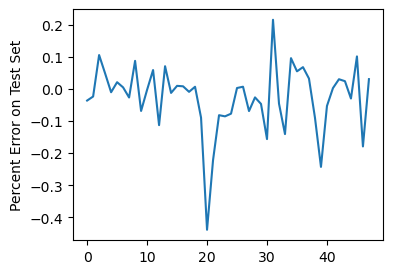

In [124]:
plt.subplots(figsize=(4,3))
plt.plot((gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
plt.ylabel('Percent Error on Test Set')

In [125]:
df01.shape

(477, 11)

In [20]:
# Calculating percent error for whole dataset using cross validation. Hyperparameters are alpha=0.025, l1_ratio=1
XY = df01.sample(frac=1)
X, Y = XY.drop(columns='Revenue'), XY[['Revenue']]
batch_size = 96

percent_error = np.zeros(df00.shape[0])

for i in range(int(df01.shape[0]/batch_size)):
    start, stop = i*batch_size, (i+1)*batch_size
    x_train, x_test = pd.concat([X.iloc[:start], X.iloc[stop:]]), X.iloc[start:stop]
    y_train, y_test = pd.concat([Y.iloc[:start], Y.iloc[stop:]]), Y.iloc[start:stop]
    
    x_train, x_test = features.fit_transform(x_train), features.transform(x_test)
    
    lr_model = ElasticNet(alpha=0.025, l1_ratio=1)
    lr_model.fit(x_train, y_train)
    
    percent_error[start:stop] = (lr_model.predict(x_test) - y_test.values.reshape(-1))/y_test.values.reshape(-1)

Mean absolute percent error (%): 6.43
Std absolute percent error (%): 10.63
Mean percent error (%): 1.04
Std percent error (%): 12.38
Median percent error (%): 0.00


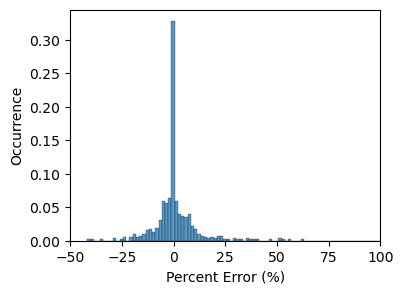

In [21]:
plt.subplots(figsize=(4,3))
sns.histplot(percent_error*100, stat='probability')
plt.xlim([-50, 100])
plt.ylabel('Occurrence')
plt.xlabel('Percent Error (%)')
print('Mean absolute percent error (%): {:.2f}'.format(np.mean(np.abs(percent_error))*100))
print('Std absolute percent error (%): {:.2f}'.format(np.std(np.abs(percent_error))*100))
print('Mean percent error (%): {:.2f}'.format(np.mean(percent_error)*100))
print('Std percent error (%): {:.2f}'.format(np.std(percent_error)*100))
print('Median percent error (%): {:.2f}'.format(np.median(percent_error)*100))

In [129]:
print(X.columns.drop(['Tech Support', 'Discount']))
print(lr_model.coef_)

Index(['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'IT Spend',
       'Employee Count', 'PC Count', 'Size'],
      dtype='object')
[ 3903.52112368  2175.88726406   299.53445628  1100.70798565
  -306.40439338    50.35845099 -2180.29181054 -6680.05425666]


##### Tech Support, Discount <a id='mlr_ts_d'></a>

**Result:**
- Size, Global Flag, Major Flag, PC Count are most important
- Stats:
    - Mean absolute percent error (%): 2.96
    - Std absolute percent error (%): 3.74
    - Mean percent error (%): 0.20
    - Std percent error (%): 4.77
    - Median percent error (%): 0.00

In [130]:
# split train, test
columns = df11.columns.drop('Revenue')
x_train, x_test, y_train, y_test = train_test_split(df11.drop(columns='Revenue'), df11[['Revenue']], test_size=0.1)

x_train, x_test = features.fit_transform(x_train), features.transform(x_test)

In [131]:
# scoring on mean absolute error
lr_model = ElasticNet()
grid_params = {'alpha':np.arange(0.025, 0.15, 0.025), 'l1_ratio':np.arange(0.85, 1, 0.025)}
gridsearch_lr = GridSearchCV(lr_model, grid_params, scoring='neg_root_mean_squared_error', return_train_score=True, cv=5)

In [132]:
gridsearch_lr.fit(x_train, y_train)
abs_percent_error = np.abs((gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
print(gridsearch_lr.best_estimator_)
print('neg mean absolute error (on val): {:.2f}'.format(gridsearch_lr.best_score_))
print('mean absolute percent error (on test): {:.2f}'.format(np.mean(abs_percent_error)))
print('std absolute percent error (on test): {:.2f}'.format(np.std(abs_percent_error)))
print('percent error (on test): {:.4f}'.format(np.sum(gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/np.sum(y_test.values)))

ElasticNet(alpha=0.025, l1_ratio=1.0)
neg mean absolute error (on val): -1000.83
mean absolute percent error (on test): 0.03
std absolute percent error (on test): 0.03
percent error (on test): -0.0094


Text(0, 0.5, 'Percent Error on Test Set')

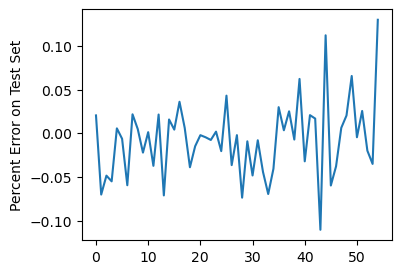

In [133]:
plt.subplots(figsize=(4,3))
plt.plot((gridsearch_lr.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
plt.ylabel('Percent Error on Test Set')

In [22]:
# Calculating percent error for whole dataset using cross validation. Hyperparameters are alpha=0.025, l1_ratio=1
XY = df11.sample(frac=1)
X, Y = XY.drop(columns='Revenue'), XY[['Revenue']]
batch_size = 109

percent_error = np.zeros(df11.shape[0])

for i in range(int(df11.shape[0]/batch_size)):
    start, stop = i*batch_size, (i+1)*batch_size
    x_train, x_test = pd.concat([X.iloc[:start], X.iloc[stop:]]), X.iloc[start:stop]
    y_train, y_test = pd.concat([Y.iloc[:start], Y.iloc[stop:]]), Y.iloc[start:stop]
    
    x_train, x_test = features.fit_transform(x_train), features.transform(x_test)
    
    lr_model = ElasticNet(alpha=0.025, l1_ratio=1)
    lr_model.fit(x_train, y_train)
    
    percent_error[start:stop] = (lr_model.predict(x_test) - y_test.values.reshape(-1))/y_test.values.reshape(-1)

Mean absolute percent error (%): 2.93
Std absolute percent error (%): 3.67
Mean percent error (%): 0.14
Std percent error (%): 4.70
Median percent error (%): 0.00


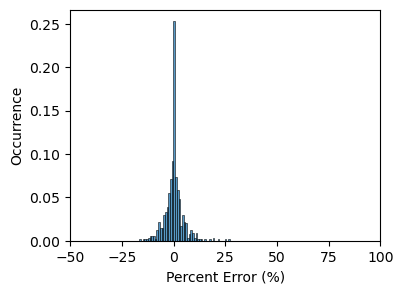

In [24]:
plt.subplots(figsize=(4,3))
sns.histplot(percent_error*100, stat='probability')
plt.xlim([-50, 100])
plt.ylabel('Occurrence')
plt.xlabel('Percent Error (%)')
print('Mean absolute percent error (%): {:.2f}'.format(np.mean(np.abs(percent_error))*100))
print('Std absolute percent error (%): {:.2f}'.format(np.std(np.abs(percent_error))*100))
print('Mean percent error (%): {:.2f}'.format(np.mean(percent_error)*100))
print('Std percent error (%): {:.2f}'.format(np.std(percent_error)*100))
print('Median percent error (%): {:.2f}'.format(np.median(percent_error)*100))

In [138]:
print(X.columns.drop(['Tech Support', 'Discount']))
print(lr_model.coef_)

Index(['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'IT Spend',
       'Employee Count', 'PC Count', 'Size'],
      dtype='object')
[  4093.8129529    2015.0759399     269.11306576   1041.88037072
   -263.82455152   -281.17846222  -1981.08677593 -14797.254846  ]


#### Random Forest <a id='random_forest_t-learner'></a>

**Result:**
- 9% (10.5% std) mean absolute error for treated groups
- Does not perform well on untreated group and does worse than LR model

##### No Tech Support, No Discount <a id='rf_no_ts_no_d'></a>

**Result:**
- PC Count, Employee Count, and Size are now the 3 most important features
- Stats
    - Mean absolute percent error (%): 20.07
    - Std absolute percent error (%): 43.51
    - Mean percent error (%): 7.71
    - Std percent error (%): 47.29
    - Median percent error (%): 0.00

In [66]:
# split train, test
columns = df00.columns.drop('Revenue')
x_train, x_test, y_train, y_test = train_test_split(df00.drop(columns='Revenue'), df00[['Revenue']], test_size=0.1)

x_train, x_test = features.fit_transform(x_train), features.transform(x_test)

In [67]:
# scoring on mean absolute error
rf_model = RandomForestRegressor()
grid_params = {'n_estimators':[125, 150, 175], 
               'criterion':['squared_error','absolute_error'],
               'max_samples':[0.25, 0.5],
               'max_features':[0.25, 0.5]}
gridsearch_rf = GridSearchCV(rf_model, grid_params, return_train_score=True, cv=5)

In [68]:
gridsearch_rf.fit(x_train, np.ravel(y_train))
abs_percent_error = np.abs((gridsearch_rf.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
print(gridsearch_rf.best_estimator_)
print('neg mean absolute error (on val): {:.2f}'.format(gridsearch_rf.best_score_))
print('mean absolute percent error (on test): {:.2f}'.format(np.mean(abs_percent_error)))
print('std absolute percent error (on test): {:.2f}'.format(np.std(abs_percent_error)))
print('percent error (on test): {:.4f}'.format(np.sum(gridsearch_rf.predict(x_test).reshape(-1,1) - y_test.values)/np.sum(y_test.values)))

RandomForestRegressor(max_features=0.5, max_samples=0.5, n_estimators=175)
neg mean absolute error (on val): 0.79
mean absolute percent error (on test): 0.20
std absolute percent error (on test): 0.23
percent error (on test): 0.0099


Text(0, 0.5, 'Percent Error on Test Set')

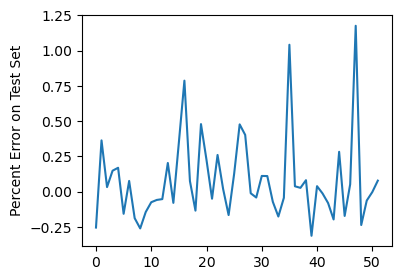

In [69]:
plt.subplots(figsize=(4,3))
plt.plot((gridsearch_rf.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
plt.ylabel('Percent Error on Test Set')

In [70]:
# Calculating percent error for whole dataset using cross validation. 
# Hyperparameters are n_estimators=175, criterion='squared_error', max_samples=0.5, max_features=0.5
XY = df00.sample(frac=1)
X, Y = XY.drop(columns='Revenue'), XY[['Revenue']]
batch_size = 104

percent_error = np.zeros(df00.shape[0])

for i in range(int(df00.shape[0]/batch_size)):
    start, stop = i*batch_size, (i+1)*batch_size
    x_train, x_test = pd.concat([X.iloc[:start], X.iloc[stop:]]), X.iloc[start:stop]
    y_train, y_test = pd.concat([Y.iloc[:start], Y.iloc[stop:]]), Y.iloc[start:stop]
    
    x_train, x_test = features.fit_transform(x_train), features.transform(x_test)
    
    rf_model = RandomForestRegressor(n_estimators=175, criterion='squared_error', max_samples=0.5, max_features=0.5)
    rf_model.fit(x_train, np.ravel(y_train))
    
    percent_error[start:stop] = (rf_model.predict(x_test) - y_test.values.reshape(-1))/y_test.values.reshape(-1)

Mean absolute percent error (%): 20.07
Std absolute percent error (%): 43.51
Mean percent error (%): 7.71
Std percent error (%): 47.29
Median percent error (%): 0.00


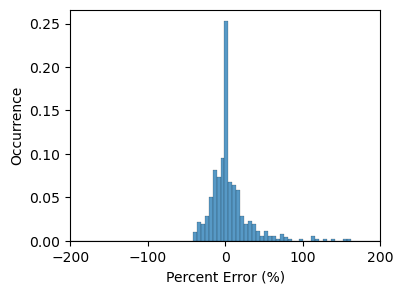

In [71]:
plt.subplots(figsize=(4,3))
sns.histplot(percent_error*100, stat='probability')
plt.xlim([-200, 200])
plt.ylabel('Occurrence')
plt.xlabel('Percent Error (%)')
print('Mean absolute percent error (%): {:.2f}'.format(np.mean(np.abs(percent_error))*100))
print('Std absolute percent error (%): {:.2f}'.format(np.std(np.abs(percent_error))*100))
print('Mean percent error (%): {:.2f}'.format(np.mean(percent_error)*100))
print('Std percent error (%): {:.2f}'.format(np.std(percent_error)*100))
print('Median percent error (%): {:.2f}'.format(np.median(percent_error)*100))

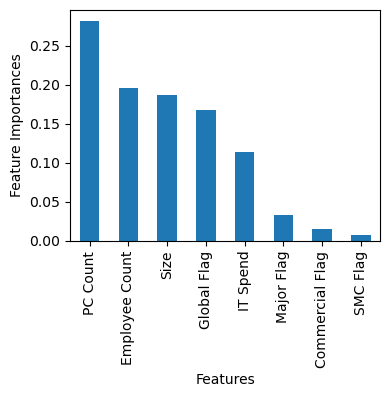

In [74]:
plt.subplots(figsize=(4,3))
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns.drop(['Tech Support', 'Discount'])).sort_values(ascending=False)
feature_importances.plot.bar()
plt.ylabel('Feature Importances')
plt.xlabel('Features');

##### Tech Support, No Discount <a id='rf_ts_no_d'></a>

**Result:**
- Size, IT Spend, PC Count most important
- Stats:
    - Mean absolute percent error (%): 9.66
    - Std absolute percent error (%): 8.87
    - Mean percent error (%): 1.49
    - Std percent error (%): 13.03
    - Median percent error (%): 0.03

In [75]:
# split train, test
columns = df10.columns.drop(['Tech Support', 'Discount', 'Revenue'])
x_train, x_test, y_train, y_test = train_test_split(df10.drop(columns='Revenue'), df10[['Revenue']], test_size=0.1)

x_train, x_test = features.fit_transform(x_train), features.transform(x_test)

In [76]:
# scoring on mean absolute error
rf_model = RandomForestRegressor()
grid_params = {'n_estimators':[125, 150, 175], 
               'criterion':['squared_error','absolute_error'],
               'max_samples':[0.25, 0.5],
               'max_features':[0.25, 0.5]}
gridsearch_rf = GridSearchCV(rf_model, grid_params, return_train_score=True, cv=5)

In [77]:
gridsearch_rf.fit(x_train, np.ravel(y_train))
abs_percent_error = np.abs((gridsearch_rf.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
print(gridsearch_rf.best_estimator_)
print('neg mean absolute error (on val): {:.2f}'.format(gridsearch_rf.best_score_))
print('mean absolute percent error (on test): {:.2f}'.format(np.mean(abs_percent_error)))
print('std absolute percent error (on test): {:.2f}'.format(np.std(abs_percent_error)))
print('percent error (on test): {:.4f}'.format(np.sum(gridsearch_rf.predict(x_test).reshape(-1,1) - y_test.values)/np.sum(y_test.values)))

RandomForestRegressor(max_features=0.5, max_samples=0.5, n_estimators=125)
neg mean absolute error (on val): 0.86
mean absolute percent error (on test): 0.08
std absolute percent error (on test): 0.08
percent error (on test): 0.0109


Text(0, 0.5, 'Percent Error on Test Set')

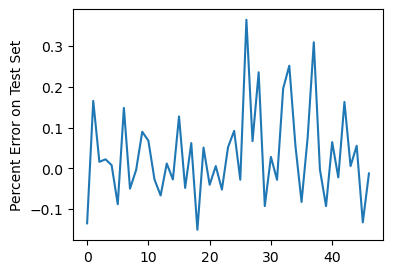

In [78]:
plt.subplots(figsize=(4,3))
plt.plot((gridsearch_rf.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
plt.ylabel('Percent Error on Test Set')

In [90]:
# Calculating percent error for whole dataset using cross validation. 
# Hyperparameters are n_estimators=125, criterion='squared_error', max_samples=0.5, max_features=0.5
XY = df10.sample(frac=1)
X, Y = XY.drop(columns='Revenue'), XY[['Revenue']]
batch_size = 93

percent_error = np.zeros(df10.shape[0])

for i in range(int(df00.shape[0]/batch_size)):
    start, stop = i*batch_size, (i+1)*batch_size
    x_train, x_test = pd.concat([X.iloc[:start], X.iloc[stop:]]), X.iloc[start:stop]
    y_train, y_test = pd.concat([Y.iloc[:start], Y.iloc[stop:]]), Y.iloc[start:stop]
    
    x_train, x_test = features.fit_transform(x_train), features.transform(x_test)
    
    rf_model = RandomForestRegressor(n_estimators=125, criterion='squared_error', max_samples=0.5, max_features=0.5)
    rf_model.fit(x_train, np.ravel(y_train))
    
    percent_error[start:stop] = (rf_model.predict(x_test) - y_test.values.reshape(-1))/y_test.values.reshape(-1)

Mean absolute percent error (%): 9.66
Std absolute percent error (%): 8.87
Mean percent error (%): 1.49
Std percent error (%): 13.03
Median percent error (%): 0.03


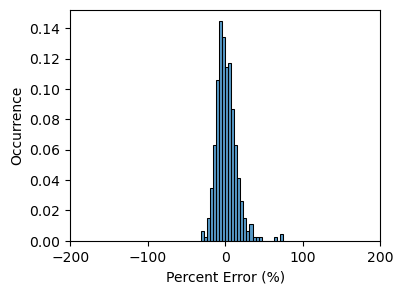

In [91]:
plt.subplots(figsize=(4,3))
sns.histplot(percent_error*100, stat='probability')
plt.xlim([-200, 200])
plt.ylabel('Occurrence')
plt.xlabel('Percent Error (%)')
print('Mean absolute percent error (%): {:.2f}'.format(np.mean(np.abs(percent_error))*100))
print('Std absolute percent error (%): {:.2f}'.format(np.std(np.abs(percent_error))*100))
print('Mean percent error (%): {:.2f}'.format(np.mean(percent_error)*100))
print('Std percent error (%): {:.2f}'.format(np.std(percent_error)*100))
print('Median percent error (%): {:.2f}'.format(np.median(percent_error)*100))

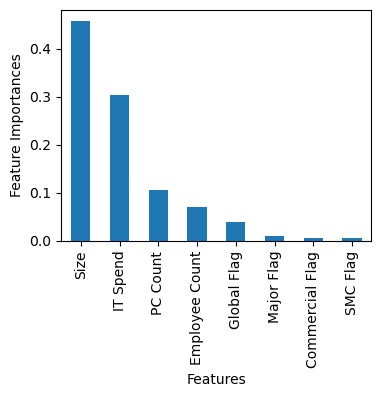

In [92]:
plt.subplots(figsize=(4,3))
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns.drop(['Tech Support', 'Discount'])).sort_values(ascending=False)
feature_importances.plot.bar()
plt.ylabel('Feature Importances')
plt.xlabel('Features');

##### No Tech Support, Discount <a id='rf_no_ts_d'></a>

**Result:**
- Size, IT Spend, PC Count most important
- Stats:
    - Mean absolute percent error (%): 11.24
    - Std absolute percent error (%): 16.08
    - Mean percent error (%): 2.87
    - Std percent error (%): 19.41
    - Median percent error (%): 0.00

In [82]:
# split train, test
columns = df01.columns.drop('Revenue')
x_train, x_test, y_train, y_test = train_test_split(df01.drop(columns='Revenue'), df01[['Revenue']], test_size=0.1)

x_train, x_test = features.fit_transform(x_train), features.transform(x_test)

In [83]:
# scoring on mean absolute error
rf_model = RandomForestRegressor()
grid_params = {'n_estimators':[125, 150, 175], 
               'criterion':['squared_error','absolute_error'],
               'max_samples':[0.25, 0.5],
               'max_features':[0.25, 0.5]}
gridsearch_rf = GridSearchCV(rf_model, grid_params, return_train_score=True, cv=5)

In [84]:
gridsearch_rf.fit(x_train, np.ravel(y_train))
abs_percent_error = np.abs((gridsearch_rf.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
print(gridsearch_rf.best_estimator_)
print('neg mean absolute error (on val): {:.2f}'.format(gridsearch_rf.best_score_))
print('mean absolute percent error (on test): {:.2f}'.format(np.mean(abs_percent_error)))
print('std absolute percent error (on test): {:.2f}'.format(np.std(abs_percent_error)))
print('percent error (on test): {:.4f}'.format(np.sum(gridsearch_rf.predict(x_test).reshape(-1,1) - y_test.values)/np.sum(y_test.values)))

RandomForestRegressor(criterion='absolute_error', max_features=0.5,
                      max_samples=0.5, n_estimators=150)
neg mean absolute error (on val): 0.92
mean absolute percent error (on test): 0.19
std absolute percent error (on test): 0.35
percent error (on test): 0.0058


Text(0, 0.5, 'Percent Error on Test Set')

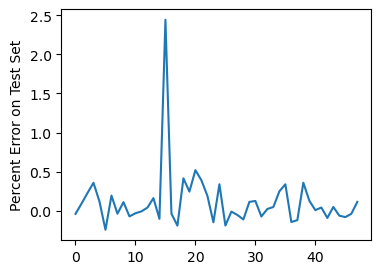

In [85]:
plt.subplots(figsize=(4,3))
plt.plot((gridsearch_rf.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
plt.ylabel('Percent Error on Test Set')

In [94]:
# Calculating percent error for whole dataset using cross validation. 
# Hyperparameters are n_estimators=150, criterion='absolute_error', max_samples=0.5, max_features=0.5
XY = df01.sample(frac=1)
X, Y = XY.drop(columns='Revenue'), XY[['Revenue']]
batch_size = 96

percent_error = np.zeros(df01.shape[0])

for i in range(int(df01.shape[0]/batch_size)):
    start, stop = i*batch_size, (i+1)*batch_size
    x_train, x_test = pd.concat([X.iloc[:start], X.iloc[stop:]]), X.iloc[start:stop]
    y_train, y_test = pd.concat([Y.iloc[:start], Y.iloc[stop:]]), Y.iloc[start:stop]
    
    x_train, x_test = features.fit_transform(x_train), features.transform(x_test)
    
    rf_model = RandomForestRegressor(n_estimators=150, criterion='absolute_error', max_samples=0.5, max_features=0.5)
    rf_model.fit(x_train, np.ravel(y_train))
    
    percent_error[start:stop] = (rf_model.predict(x_test) - y_test.values.reshape(-1))/y_test.values.reshape(-1)

Mean absolute percent error (%): 11.24
Std absolute percent error (%): 16.08
Mean percent error (%): 2.87
Std percent error (%): 19.41
Median percent error (%): 0.00


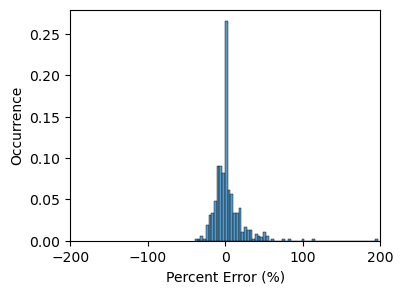

In [95]:
plt.subplots(figsize=(4,3))
sns.histplot(percent_error*100, stat='probability')
plt.xlim([-200, 200])
plt.ylabel('Occurrence')
plt.xlabel('Percent Error (%)')
print('Mean absolute percent error (%): {:.2f}'.format(np.mean(np.abs(percent_error))*100))
print('Std absolute percent error (%): {:.2f}'.format(np.std(np.abs(percent_error))*100))
print('Mean percent error (%): {:.2f}'.format(np.mean(percent_error)*100))
print('Std percent error (%): {:.2f}'.format(np.std(percent_error)*100))
print('Median percent error (%): {:.2f}'.format(np.median(percent_error)*100))

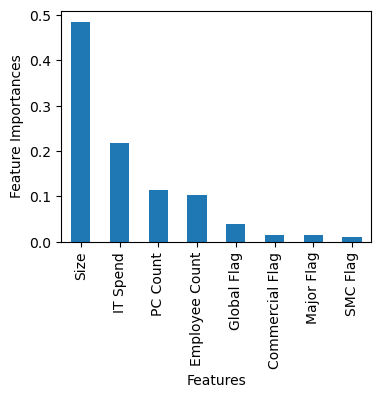

In [96]:
plt.subplots(figsize=(4,3))
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns.drop(['Tech Support', 'Discount'])).sort_values(ascending=False)
feature_importances.plot.bar()
plt.ylabel('Feature Importances')
plt.xlabel('Features');

##### Tech Support, Discount <a id='rf_ts_d'></a>

**Result:**
- Size, IT Spend, PC Count most important
- Stats:
    - Mean absolute percent error (%): 5.80
    - Std absolute percent error (%): 6.72
    - Mean percent error (%): 1.18
    - Std percent error (%): 8.80
    - Median percent error (%): 0.00

In [97]:
# split train, test
columns = df11.columns.drop('Revenue')
x_train, x_test, y_train, y_test = train_test_split(df11.drop(columns='Revenue'), df11[['Revenue']], test_size=0.1)

x_train, x_test = features.fit_transform(x_train), features.transform(x_test)

In [98]:
# scoring on mean absolute error
rf_model = RandomForestRegressor()
grid_params = {'n_estimators':[125, 150, 175], 
               'criterion':['squared_error','absolute_error'],
               'max_samples':[0.25, 0.5],
               'max_features':[0.25, 0.5]}
gridsearch_rf = GridSearchCV(rf_model, grid_params, return_train_score=True, cv=5)

In [99]:
gridsearch_rf.fit(x_train, np.ravel(y_train))
abs_percent_error = np.abs((gridsearch_rf.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
print(gridsearch_rf.best_estimator_)
print('neg mean absolute error (on val): {:.2f}'.format(gridsearch_rf.best_score_))
print('mean absolute percent error (on test): {:.2f}'.format(np.mean(abs_percent_error)))
print('std absolute percent error (on test): {:.2f}'.format(np.std(abs_percent_error)))
print('percent error (on test): {:.4f}'.format(np.sum(gridsearch_rf.predict(x_test).reshape(-1,1) - y_test.values)/np.sum(y_test.values)))

RandomForestRegressor(max_features=0.5, max_samples=0.5, n_estimators=175)
neg mean absolute error (on val): 0.96
mean absolute percent error (on test): 0.08
std absolute percent error (on test): 0.09
percent error (on test): -0.0101


Text(0, 0.5, 'Percent Error on Test Set')

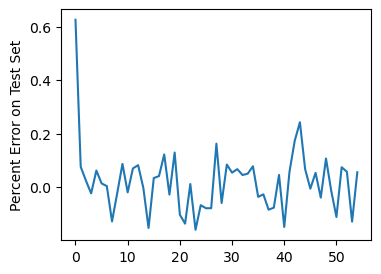

In [100]:
plt.subplots(figsize=(4,3))
plt.plot((gridsearch_rf.predict(x_test).reshape(-1,1) - y_test.values)/y_test.values)
plt.ylabel('Percent Error on Test Set')

In [102]:
# Calculating percent error for whole dataset using cross validation. 
# Hyperparameters are n_estimators=175, criterion='squared_error', max_samples=0.5, max_features=0.5
XY = df11.sample(frac=1)
X, Y = XY.drop(columns='Revenue'), XY[['Revenue']]
batch_size = 109

percent_error = np.zeros(df11.shape[0])

for i in range(int(df11.shape[0]/batch_size)):
    start, stop = i*batch_size, (i+1)*batch_size
    x_train, x_test = pd.concat([X.iloc[:start], X.iloc[stop:]]), X.iloc[start:stop]
    y_train, y_test = pd.concat([Y.iloc[:start], Y.iloc[stop:]]), Y.iloc[start:stop]
    
    x_train, x_test = features.fit_transform(x_train), features.transform(x_test)
    
    rf_model = RandomForestRegressor(n_estimators=175, criterion='squared_error', max_samples=0.5, max_features=0.5)
    rf_model.fit(x_train, np.ravel(y_train))
    
    percent_error[start:stop] = (rf_model.predict(x_test) - y_test.values.reshape(-1))/y_test.values.reshape(-1)

Mean absolute percent error (%): 5.80
Std absolute percent error (%): 6.72
Mean percent error (%): 1.18
Std percent error (%): 8.80
Median percent error (%): 0.00


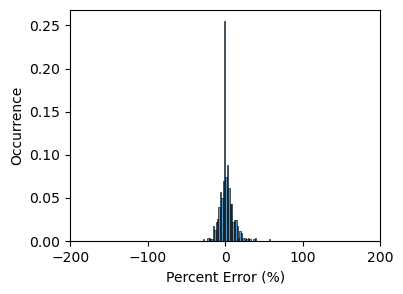

In [103]:
plt.subplots(figsize=(4,3))
sns.histplot(percent_error*100, stat='probability')
plt.xlim([-200, 200])
plt.ylabel('Occurrence')
plt.xlabel('Percent Error (%)')
print('Mean absolute percent error (%): {:.2f}'.format(np.mean(np.abs(percent_error))*100))
print('Std absolute percent error (%): {:.2f}'.format(np.std(np.abs(percent_error))*100))
print('Mean percent error (%): {:.2f}'.format(np.mean(percent_error)*100))
print('Std percent error (%): {:.2f}'.format(np.std(percent_error)*100))
print('Median percent error (%): {:.2f}'.format(np.median(percent_error)*100))

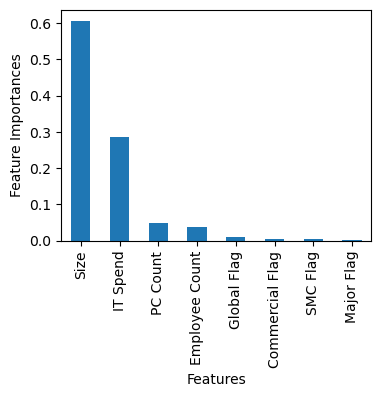

In [104]:
plt.subplots(figsize=(4,3))
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns.drop(['Tech Support', 'Discount'])).sort_values(ascending=False)
feature_importances.plot.bar()
plt.ylabel('Feature Importances')
plt.xlabel('Features');

## Cumulative Gain <a id='cumulative_gain'></a>

**Result:**
- Difference between S-Learner and T-Learner are minimal and qualitatively identical
- Company should consider incorporating tech support as a baseline service or as an add-on
    - Gains curve suggests offering tech support increases revenue for all customers
    - Cost of offering tech support should not exceed $7000 per customer
- Offering a discount (not clear what percentage is for discount) is effective for 98% of customers
    - Offering a discount to just half of the customers will attract 87% of the total gain

### S-Learner <a id='cum_gain_s-learner'></a>

**Result:**
- Should offer tech support to all customers as long as the cost for operating tech support does not exceed $6900 per customer
- Should offer a discount to 98.65% of customers

In [25]:
df_s_model = df.sample(frac=1)
n = df_s_model.shape[0]
df_s_model['Y00'] = np.zeros(n)
df_s_model['Y10'] = np.zeros(n)
df_s_model['Y01'] = np.zeros(n)
df_s_model['Y11'] = np.zeros(n)

features = FeatureUnion([
    ('bin_trans', ColumnTransformer([('flags', 'passthrough', ['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag'])])),
    ('it_trans', NumericalTransformer(column='IT Spend', binwidth=6000)),
    ('employee_trans', NumericalTransformer(column='Employee Count', binwidth=10)),
    ('pc_trans', NumericalTransformer(column='PC Count', binwidth=10)),
    ('size_trans', NumericalTransformer(column='Size', binwidth=20000)),
    ('treatment_trans', ColumnTransformer([('treatments', 'passthrough', ['Tech Support', 'Discount'])]))
])
s_model = RandomForestRegressor(n_estimators=125, criterion='absolute_error', max_samples=1080, max_features=7)
batch_size = int(0.25*n)

for i in range(int(1/0.25)):
    start, stop = i*batch_size, (i+1)*batch_size
    x_train, x_test = pd.concat([df_s_model.iloc[:start], df_s_model.iloc[stop:]]), df_s_model.iloc[start:stop].copy()
    x_train, x_test = features.fit_transform(x_train), features.transform(x_test)
    y_train, y_test = pd.concat([df_s_model.iloc[:start]['Revenue'], df_s_model.iloc[stop:]['Revenue']]), df_s_model.iloc[start:stop]['Revenue']
    
    s_model.fit(x_train, np.ravel(y_train))
    
    df_s_model.iloc[start:stop,-4] = s_model.predict(np.concatenate((x_test[:,:-2], np.array([[0,0]]*batch_size)), axis=1))
    df_s_model.iloc[start:stop,-3] = s_model.predict(np.concatenate((x_test[:,:-2], np.array([[1,0]]*batch_size)), axis=1))
    df_s_model.iloc[start:stop,-2] = s_model.predict(np.concatenate((x_test[:,:-2], np.array([[0,1]]*batch_size)), axis=1))
    df_s_model.iloc[start:stop,-1] = s_model.predict(np.concatenate((x_test[:,:-2], np.array([[1,1]]*batch_size)), axis=1))

C:\Users\kimvo\AppData\Local\Temp\ipykernel_6628\2436985342.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,1)


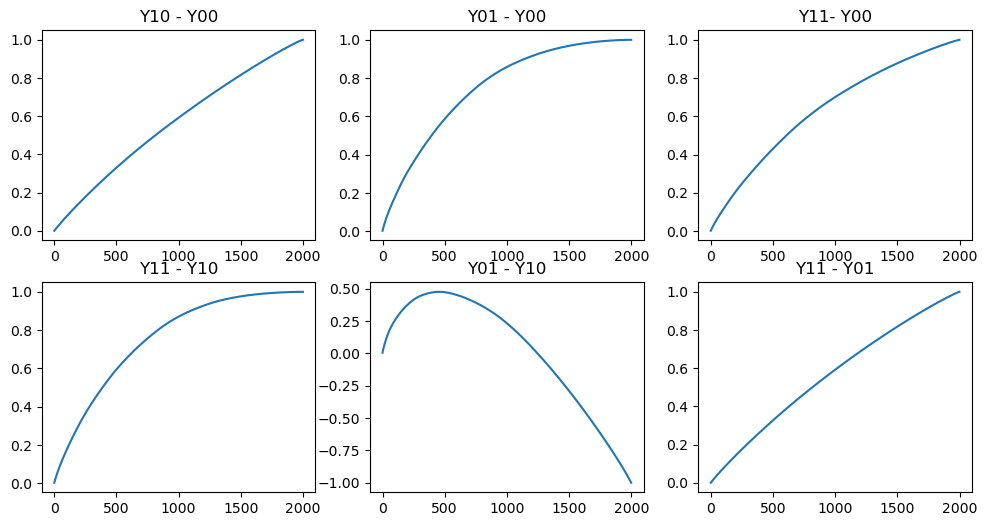

In [26]:
plt.subplots(figsize=(12,6))
plt.subplot(2,3,1)
my_sum = np.cumsum(np.sort(df_s_model['Y10'] - df_s_model['Y00'])[::-1])
plt.plot(my_sum/my_sum[-1])
plt.title('Y10 - Y00')
plt.subplot(2,3,2)
plt.title('Y01 - Y00')
my_sum = np.cumsum(np.sort(df_s_model['Y01'] - df_s_model['Y00'])[::-1])
plt.plot(my_sum/my_sum[-1])
plt.subplot(2,3,3)
plt.title('Y11- Y00')
my_sum = np.cumsum(np.sort(df_s_model['Y11'] - df_s_model['Y00'])[::-1])
plt.plot(my_sum/my_sum[-1])
plt.subplot(2,3,4)
plt.title('Y11 - Y10')
my_sum = np.cumsum(np.sort(df_s_model['Y11'] - df_s_model['Y10'])[::-1])
plt.plot(my_sum/my_sum[-1])
plt.subplot(2,3,5)
plt.title('Y01 - Y10')
my_sum = np.cumsum(np.sort(df_s_model['Y01'] - df_s_model['Y10'])[::-1])
plt.plot(-my_sum/my_sum[-1])
plt.subplot(2,3,6)
plt.title('Y11 - Y01')
my_sum = np.cumsum(np.sort(df_s_model['Y11'] - df_s_model['Y01'])[::-1])
plt.plot(my_sum/my_sum[-1])

C:\Users\kimvo\AppData\Local\Temp\ipykernel_6628\2831323458.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


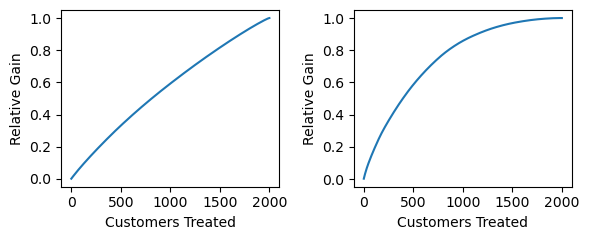

In [31]:
plt.subplots(figsize=(6,2.5))
plt.subplot(1,2,1)
my_sum = np.cumsum(np.sort(df_s_model['Y10'] - df_s_model['Y00'])[::-1])
plt.plot(my_sum/my_sum[-1])
plt.ylabel('Relative Gain')
plt.xlabel('Customers Treated')
plt.subplot(1,2,2)
my_sum = np.cumsum(np.sort(df_s_model['Y01'] - df_s_model['Y00'])[::-1])
plt.plot(my_sum/my_sum[-1])
plt.ylabel('Relative Gain')
plt.xlabel('Customers Treated')
plt.tight_layout()

In [33]:
np.cumsum(np.sort(df_s_model['Y01'] - df_s_model['Y00'])[::-1])[-1]

10253881.214201784

In [47]:
(np.cumsum(np.sort(df_s_model['Y11'] - df_s_model['Y10'])[::-1])/(np.cumsum(np.sort(df_s_model['Y11'] - df_s_model['Y10'])[::-1])[-1]))[1000]

0.869043389768047

In [11]:
np.cumsum(np.sort(df_s_model['Y10'] - df_s_model['Y00'])[::-1])[-1]/2000

6929.604337386701

In [17]:
np.argwhere(np.cumsum(np.sort(df_s_model['Y11'] - df_s_model['Y10'])[::-1]) == max(np.cumsum(np.sort(df_s_model['Y11'] - df_s_model['Y10'])[::-1])))

array([[1972]], dtype=int64)

In [16]:
1973/2000

0.9865

Should offer tech support to all customers as long as the cost for operating tech support does not exceed $6900 per customer \
Should offer a discount to 98.65% of customers

### T-Learner <a id='cum_gain_t-learner'></a>

**Result:**
- Should offer tech support to all customers so long as the cost of offering tech support does not exceed $7260 per customer
- Should offer discount to 98.25% of customers

In [27]:
# splitting df by treatment variables. 
# Using df00 to designate no tech support and no discount, df10 to designate tech support and no discount, etc.
df00 = df[(df['Tech Support']==0) & (df['Discount']==0)].copy()
df10 = df[(df['Tech Support']==1) & (df['Discount']==0)].copy()
df01 = df[(df['Tech Support']==0) & (df['Discount']==1)].copy()
df11 = df[(df['Tech Support']==1) & (df['Discount']==1)].copy()

features = FeatureUnion([
    ('bin_trans', ColumnTransformer([('flags', 'passthrough', ['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag'])])),
    ('it_trans', NumericalTransformer(column='IT Spend', binwidth=6000)),
    ('employee_trans', NumericalTransformer(column='Employee Count', binwidth=10)),
    ('pc_trans', NumericalTransformer(column='PC Count', binwidth=10)),
    ('size_trans', NumericalTransformer(column='Size', binwidth=20000))
])

In [28]:
Y00_model = ElasticNet(alpha=0.025, l1_ratio=0.975)
Y00_model.fit(features.fit_transform(df00), df00[['Revenue']])
df00['Y00'] = df00['Revenue']
df10['Y00'] = Y00_model.predict(features.transform(df10))
df01['Y00'] = Y00_model.predict(features.transform(df01))
df11['Y00'] = Y00_model.predict(features.transform(df11))

Y10_model = ElasticNet(alpha=0.025, l1_ratio=0.975)
Y10_model.fit(features.fit_transform(df10), df10[['Revenue']])
df00['Y10'] = Y10_model.predict(features.transform(df00))
df10['Y10'] = df10['Revenue']
df01['Y10'] = Y10_model.predict(features.transform(df01))
df11['Y10'] = Y10_model.predict(features.transform(df11))

Y01_model = ElasticNet(alpha=0.025, l1_ratio=1)
Y01_model.fit(features.fit_transform(df01), df01[['Revenue']])
df00['Y01'] = Y01_model.predict(features.transform(df00))
df10['Y01'] = Y01_model.predict(features.transform(df10))
df01['Y01'] = df01['Revenue']
df11['Y01'] = Y01_model.predict(features.transform(df11))

Y11_model = ElasticNet(alpha=0.025, l1_ratio=1)
Y11_model.fit(features.fit_transform(df11), df11[['Revenue']])
df00['Y11'] = Y11_model.predict(features.transform(df00))
df10['Y11'] = Y11_model.predict(features.transform(df10))
df01['Y11'] = Y11_model.predict(features.transform(df01))
df11['Y11'] = df11['Revenue'];

In [29]:
df_t_model = pd.concat([df00, df10, df01, df11])

C:\Users\kimvo\AppData\Local\Temp\ipykernel_10212\3409041012.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,1)


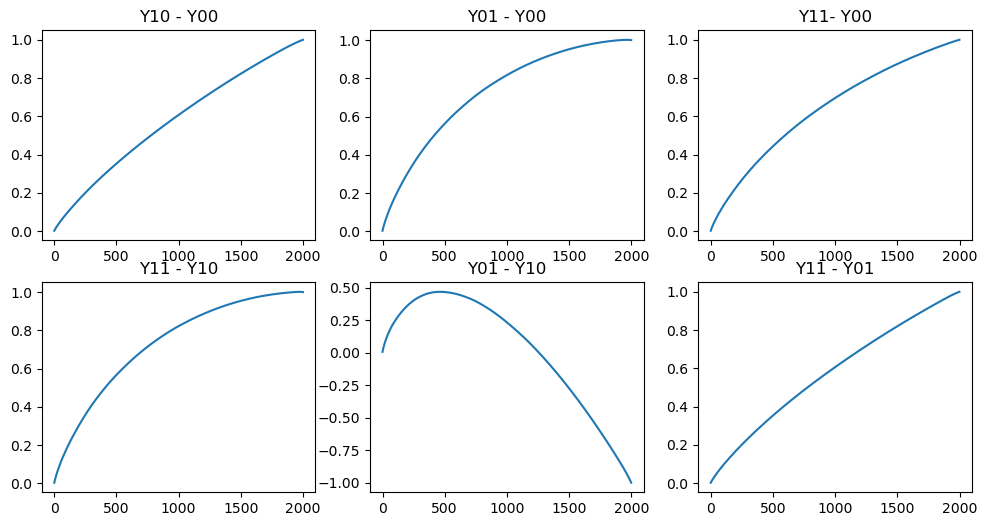

In [30]:
plt.subplots(figsize=(12,6))
plt.subplot(2,3,1)
my_sum = np.cumsum(np.sort(df_t_model['Y10'] - df_t_model['Y00'])[::-1])
plt.plot(my_sum/my_sum[-1])
plt.title('Y10 - Y00')
plt.subplot(2,3,2)
plt.title('Y01 - Y00')
my_sum = np.cumsum(np.sort(df_t_model['Y01'] - df_t_model['Y00'])[::-1])
plt.plot(my_sum/my_sum[-1])
plt.subplot(2,3,3)
plt.title('Y11- Y00')
my_sum = np.cumsum(np.sort(df_t_model['Y11'] - df_t_model['Y00'])[::-1])
plt.plot(my_sum/my_sum[-1])
plt.subplot(2,3,4)
plt.title('Y11 - Y10')
my_sum = np.cumsum(np.sort(df_t_model['Y11'] - df_t_model['Y10'])[::-1])
plt.plot(my_sum/my_sum[-1])
plt.subplot(2,3,5)
plt.title('Y01 - Y10')
my_sum = np.cumsum(np.sort(df_t_model['Y01'] - df_t_model['Y10'])[::-1])
plt.plot(-my_sum/my_sum[-1])
plt.subplot(2,3,6)
plt.title('Y11 - Y01')
my_sum = np.cumsum(np.sort(df_t_model['Y11'] - df_t_model['Y01'])[::-1])
plt.plot(my_sum/my_sum[-1])

Should offer tech support to all customers so long as the cost of offering tech support does not exceed $7260 per customer \
Should offer discount to 98.25% of customers

C:\Users\kimvo\AppData\Local\Temp\ipykernel_6628\1872648889.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


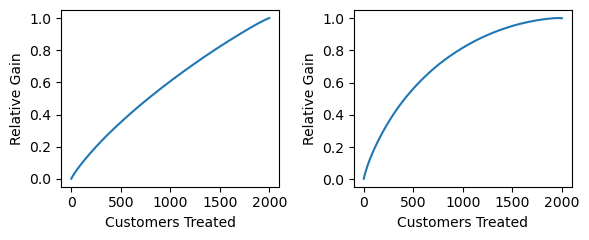

In [38]:
plt.subplots(figsize=(6,2.5))
plt.subplot(1,2,1)
my_sum = np.cumsum(np.sort(df_t_model['Y10'] - df_t_model['Y00'])[::-1])
plt.plot(my_sum/my_sum[-1])
plt.ylabel('Relative Gain')
plt.xlabel('Customers Treated')
plt.subplot(1,2,2)
my_sum = np.cumsum(np.sort(df_t_model['Y01'] - df_t_model['Y00'])[::-1])
plt.plot(my_sum/my_sum[-1])
plt.ylabel('Relative Gain')
plt.xlabel('Customers Treated')
plt.tight_layout()

(0.0, 0.5)

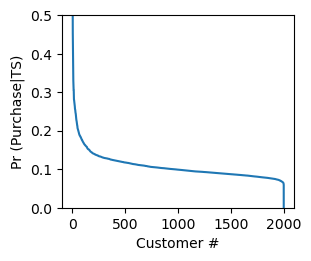

In [54]:
plt.subplots(figsize=(3,2.5))
plt.plot(np.sort(df_t_model['Y10']/(df_t_model['Y00']/0.05))[::-1])
plt.ylabel('Pr (Purchase|TS)')
plt.xlabel('Customer #')
plt.ylim(0,0.5)

In [48]:
np.median(np.sort(df_t_model['Y10']/(df_t_model['Y00']/0.05))[::-1])

0.09886323556823222

Text(0.5, 0, 'Customer #')

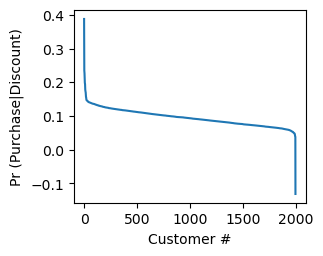

In [56]:
plt.subplots(figsize=(3,2.5))
plt.plot(np.sort(df_t_model['Y01']/(df_t_model['Y00']/0.05*0.9))[::-1])
plt.ylabel('Pr (Purchase|Discount)')
plt.xlabel('Customer #')
# plt.ylim(0,0.5)

In [57]:
np.median(np.sort(df_t_model['Y01']/(df_t_model['Y00']/0.05*0.9))[::-1])

0.09337783088477841

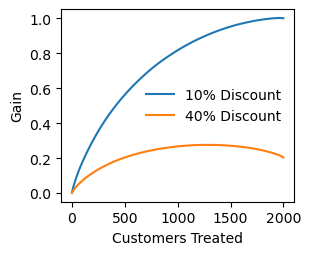

In [76]:
plt.subplots(figsize=(3,2.5))
my_sum =  np.cumsum(np.sort(df_t_model['Y01'] - df_t_model['Y00'])[::-1])
plt.plot(my_sum/my_sum[-1], label='10% Discount')
my_sum2 = np.cumsum(np.sort(df_t_model['Y01']/0.9*0.6 - df_t_model['Y00'])[::-1])
plt.plot(my_sum2/my_sum[-1], label='40% Discount')
plt.ylabel('Gain')
plt.xlabel('Customers Treated')
plt.legend(loc=7, frameon=False)

In [78]:
np.cumsum(np.sort(df_t_model['Y01'] - df_t_model['Y00'])[::-1])[-1]/2000

5738.340285343711

In [51]:
from scipy.stats import percentileofscore

In [53]:
# percentiles for top 50% of discount gain using means
print('Percentile of IT Spend : {:.2f}'.format(stats.percentileofscore(df['IT Spend'], 45899.25)))
print('Percentile of Employee Count : {:.2f}'.format(stats.percentileofscore(df['Employee Count'], 61.129)))
print('Percentile of PC Count : {:.2f}'.format(stats.percentileofscore(df['PC Count'], 57.604)))
print('Percentile of Size : {:.2f}'.format(stats.percentileofscore(df['Size'], 184038.387)))

Percentile of IT Spend : 81.20
Percentile of Employee Count : 63.70
Percentile of PC Count : 65.00
Percentile of Size : 80.80


In [54]:
# percentiles for top 50% of discount gain using min
print('Percentile of IT Spend : {:.2f}'.format(stats.percentileofscore(df['IT Spend'], 5730)))
print('Percentile of Employee Count : {:.2f}'.format(stats.percentileofscore(df['Employee Count'], 10)))
print('Percentile of PC Count : {:.2f}'.format(stats.percentileofscore(df['PC Count'], 6)))
print('Percentile of Size : {:.2f}'.format(stats.percentileofscore(df['Size'], 45745)))

Percentile of IT Spend : 14.55
Percentile of Employee Count : 0.83
Percentile of PC Count : 0.18
Percentile of Size : 28.85


In [55]:
# percentiles for top 50% of discount gain using median
print('Percentile of IT Spend : {:.2f}'.format(stats.percentileofscore(df['IT Spend'], 37846)))
print('Percentile of Employee Count : {:.2f}'.format(stats.percentileofscore(df['Employee Count'], 42)))
print('Percentile of PC Count : {:.2f}'.format(stats.percentileofscore(df['PC Count'], 41)))
print('Percentile of Size : {:.2f}'.format(stats.percentileofscore(df['Size'], 155667)))

Percentile of IT Spend : 74.80
Percentile of Employee Count : 48.38
Percentile of PC Count : 49.80
Percentile of Size : 75.00


## Cumulative Lift <a id='cumulative lift'></a>

**Result:**

Not informative.

### S-Learner <a id='cum_lift_s-learner'></a>

**Result:**

C:\Users\kimvo\AppData\Local\Temp\ipykernel_11756\586934860.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,1)


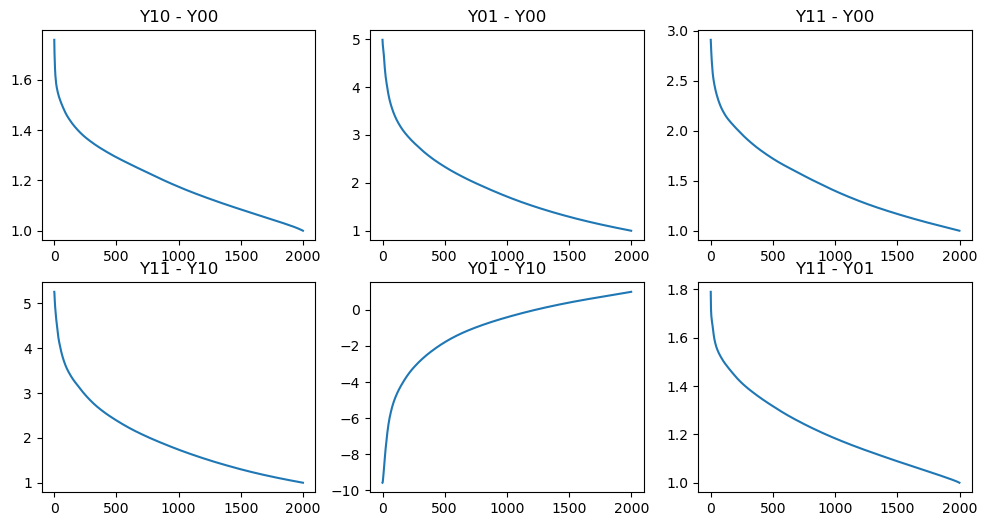

In [33]:
plt.subplots(figsize=(12,6))
plt.subplot(2,3,1)
my_cumsum = np.cumsum(np.sort(df_s_model['Y10'] - df_s_model['Y00'])[::-1])
plt.plot(my_cumsum/my_cumsum[-1]/(np.arange(1,2001)/2000))
plt.title('Y10 - Y00')
plt.subplot(2,3,2)
plt.title('Y01 - Y00')
my_cumsum = np.cumsum(np.sort(df_s_model['Y01'] - df_s_model['Y00'])[::-1])
plt.plot(my_cumsum/my_cumsum[-1]/(np.arange(1,2001)/2000))
plt.subplot(2,3,3)
plt.title('Y11 - Y00')
my_cumsum = np.cumsum(np.sort(df_s_model['Y11'] - df_s_model['Y00'])[::-1])
plt.plot(my_cumsum/my_cumsum[-1]/(np.arange(1,2001)/2000))
plt.subplot(2,3,4)
plt.title('Y11 - Y10')
my_cumsum = np.cumsum(np.sort(df_s_model['Y11'] - df_s_model['Y10'])[::-1])
plt.plot(my_cumsum/my_cumsum[-1]/(np.arange(1,2001)/2000))
plt.subplot(2,3,5)
plt.title('Y01 - Y10')
my_cumsum = np.cumsum(np.sort(df_s_model['Y01'] - df_s_model['Y10'])[::-1])
plt.plot(my_cumsum/my_cumsum[-1]/(np.arange(1,2001)/2000))
plt.subplot(2,3,6)
plt.title('Y11 - Y01')
my_cumsum = np.cumsum(np.sort(df_s_model['Y11'] - df_s_model['Y01'])[::-1])
plt.plot(my_cumsum/my_cumsum[-1]/(np.arange(1,2001)/2000))

### T-Learner <a id='cum_lift_t-learner'></a>

**Result:**

C:\Users\kimvo\AppData\Local\Temp\ipykernel_11756\2949441383.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,1)


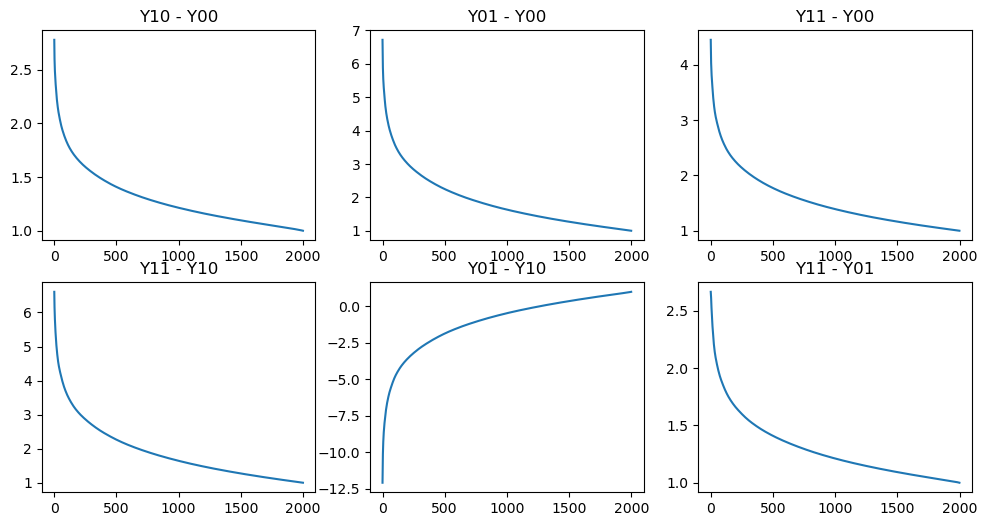

In [32]:
plt.subplots(figsize=(12,6))
plt.subplot(2,3,1)
my_cumsum = np.cumsum(np.sort(df_t_model['Y10'] - df_t_model['Y00'])[::-1])
plt.plot(my_cumsum/my_cumsum[-1]/(np.arange(1,2001)/2000))
plt.title('Y10 - Y00')
plt.subplot(2,3,2)
plt.title('Y01 - Y00')
my_cumsum = np.cumsum(np.sort(df_t_model['Y01'] - df_t_model['Y00'])[::-1])
plt.plot(my_cumsum/my_cumsum[-1]/(np.arange(1,2001)/2000))
plt.subplot(2,3,3)
plt.title('Y11 - Y00')
my_cumsum = np.cumsum(np.sort(df_t_model['Y11'] - df_t_model['Y00'])[::-1])
plt.plot(my_cumsum/my_cumsum[-1]/(np.arange(1,2001)/2000))
plt.subplot(2,3,4)
plt.title('Y11 - Y10')
my_cumsum = np.cumsum(np.sort(df_t_model['Y11'] - df_t_model['Y10'])[::-1])
plt.plot(my_cumsum/my_cumsum[-1]/(np.arange(1,2001)/2000))
plt.subplot(2,3,5)
plt.title('Y01 - Y10')
my_cumsum = np.cumsum(np.sort(df_t_model['Y01'] - df_t_model['Y10'])[::-1])
plt.plot(my_cumsum/my_cumsum[-1]/(np.arange(1,2001)/2000))
plt.subplot(2,3,6)
plt.title('Y11 - Y01')
my_cumsum = np.cumsum(np.sort(df_t_model['Y11'] - df_t_model['Y01'])[::-1])
plt.plot(my_cumsum/my_cumsum[-1]/(np.arange(1,2001)/2000))